# 2024 September | qMRI Iron and MTR from Cambridge


In [233]:
import pandas as pd
import numpy as np
import nibabel as nb
import seaborn as sns
import os
import glob
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainstat.stats.SLM import SLM
from brainstat.stats.terms import FixedEffect
from brainstat.datasets.base import combine_surfaces
import matplotlib.pyplot as plt
import matplotlib as mpl

# Path to MICAPIPE
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')
mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k_int = np.concatenate((mask_lh, mask_rh), axis=0)


# Labels and boolean mask
mask_5k = mask_5k_int != 0

# load stuff
from brainspace.datasets import load_mask
mask_32k = load_mask(join=True)

# Load canonical inflated fsLR-32k surface
inf32_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
inf32_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

# Set dataset PNI as working directory
os.chdir('/data_/mica3')

# full path to 
database = 'BIDS_cambridge'

# List of subjects
subject = '10058'

# For MIC subjects
subject_dir = glob.glob(f'{database}/derivatives/micapipe_v0.2.0/sub-{subject}')[0]

# Load native fsLR-32k surface
nat_32k_lh = read_surface(f'{subject_dir}/surf/sub-{subject}_hemi-L_space-nativepro_surf-fsLR-32k_label-midthickness.surf.gii', itype='gii')
nat_32k_rh = read_surface(f'{subject_dir}/surf/sub-{subject}_hemi-R_space-nativepro_surf-fsLR-32k_label-midthickness.surf.gii', itype='gii')


## Add alpha make the range sym as well or None

In [17]:

def plot_ridgeplot(matrix, matrix_df=None, Cmap='rocket', Range=(0.5, 2), Xlab="SUVR value", save_path=None, title=None, mean_line=False):
    """
    Parameters:
    - matrix: numpy array
        The matrix to be plotted.
    - matrix_df: pandas DataFrame, optional
        The DataFrame containing additional information about the matrix.
    - Cmap: str, optional
        The colormap to be used for the ridgeplot. Default is 'rocket'.
    - Range: tuple, optional
        The range of values for the x-axis. Default is (0.5, 2).
    - Xlab: str, optional
        The label for the x-axis. Default is "SUVR value".
    - save_path: str, optional
        The file path to save the plot. If not provided, the plot will be displayed.
    - title: str, optional
        The title of the plot.
    - mean_line: bool, optional
        Whether to plot the mean line for all distributions. Default is False.
    Returns:
    None

    Plot a ridgeplot of the given matrix.
    
    """
    if matrix_df is None:
        # Create a default DataFrame with placeholder values
        matrix_df = pd.DataFrame({'id': [f'{i+1}' for i in range(matrix.shape[0])]})

    mean_row_values = np.mean(matrix, axis=1)
    sorted_indices = np.argsort(mean_row_values)
    sorted_matrix = matrix[sorted_indices]
    sorted_id_x = matrix_df['id'].values[sorted_indices]

    ai = sorted_matrix.flatten()
    subject = np.array([])
    id_x = np.array([])

    for i in range(sorted_matrix.shape[0]):
        label = np.array([str(i+1) for j in range(sorted_matrix.shape[1])])
        subject = np.concatenate((subject, label))
        id_label = np.array([sorted_id_x[i] for j in range(sorted_matrix.shape[1])])
        id_x = np.concatenate((id_x, id_label))

    d = {'feature': ai,
         'subject': subject,
         'id_x': id_x
        }
    df = pd.DataFrame(d)

    f, axs = plt.subplots(nrows=sorted_matrix.shape[0], figsize=(3.468504*2.5, 2.220472*3.5), sharex=True, sharey=True)
    f.set_facecolor('none')

    x = np.linspace(Range[0], Range[1], 100)

    for i, ax in enumerate(axs, 1):
        sns.kdeplot(df[df["subject"]==str(i)]['feature'],
                    fill=True,
                    color="w",
                    alpha=0.25,
                    linewidth=1.5,
                    legend=False,
                    ax=ax)
        
        ax.set_xlim(Range[0], Range[1])
        
        im = ax.imshow(np.vstack([x, x]),
                       cmap=Cmap,
                       aspect="auto",
                       extent=[*ax.get_xlim(), *ax.get_ylim()]
                      )
        ax.collections
        path = ax.collections[0].get_paths()[0]
        patch = mpl.patches.PathPatch(path, transform=ax.transData)
        im.set_clip_path(patch)
           
        ax.spines[['left','right','bottom','top']].set_visible(False)
        
        if i != sorted_matrix.shape[0]:
            ax.tick_params(axis="x", length=0)
        else:
            ax.set_xlabel(Xlab)
            
        ax.set_yticks([])
        ax.set_ylabel("")
        
        ax.axhline(0, color="black")

        ax.set_facecolor("none")

    for i, ax in enumerate(axs):
        if i == sorted_matrix.shape[0] - 1:
            ax.set_xticks([Range[0], Range[1]])  # Set x-axis ticks for the bottom plot
        else:
            ax.set_xticks([])  # Remove x-axis ticks from other plots
        ax.text(0.05, 0.01, sorted_id_x[i], transform=ax.transAxes, fontsize=10, color='black', ha='left', va='bottom')

    # Calculate and add a single mean line for all subplots if mean_line is True
    if mean_line:
        mean_asym_all = np.mean(sorted_matrix)
        for ax in axs:
            ax.axvline(x=mean_asym_all, linestyle='dashed', color='black', label=f"Mean: {mean_asym_all:.2f}")

    plt.subplots_adjust(hspace=-0.8)
    
    if title:
        plt.suptitle(title, y=0.99, fontsize=16)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()
        
def plot_intensity_profile(int_profile, mask_32k, qmri, save_path=None):
    """
    Plot the mean intensity profile and scatter plot with lines.

    Parameters:
    - int_profile: numpy array
        The intensity profile matrix.
    - mask_32k: numpy array
        The mask to apply to the intensity profile.
    - qmri: str
        The qMRI type for the title.
    - save_path: str, optional
        The file path to save the plot. If not provided, the plot will be displayed.
    Returns:
    None
    """
    # Mean intensity profile
    map_mean = np.mean(int_profile, axis=0)

    # Remove NaN from the variance
    var_ft = map_mean[~np.isnan(map_mean)]
    n, bins = np.histogram(var_ft, bins=100)  # Compute the histogram data
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers

    # Use Seaborn's 'mako' colormap
    cmap = sns.color_palette("mako", as_cmap=True)
    colored_bins = cmap(np.interp(bin_centers, [np.quantile(map_mean[mask_32k], 0.01), 
                                                np.quantile(map_mean[mask_32k], 0.99)], [0, 1]))

    # Create a figure with a transparent background
    fig, ax = plt.subplots()
    fig.patch.set_alpha(0.0)  # Set the background of the figure to be transparent
    ax.patch.set_alpha(0.0)  # Set the background of the axes to be transparent

    # Plot the histogram with the desired colormap
    plt.bar(bin_centers, n, width=np.diff(bins), color=colored_bins, alpha=1)

    # Remove upper and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Customize ticks and labels
    plt.xlabel('Degree', fontsize=10)  # Increase font size for x-label
    plt.ylabel('Frequency', fontsize=10)  # Increase font size for y-label
    plt.title(f'Mean {qmri} vertex-wise', fontsize=12)  # Increase font size for title

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()

In [19]:
# Quantitative MRI
qmri = 'acq-qMRI-MTR'

# Load GM intensity profiles
gm_int = nb.load(glob.glob(f'{subject_dir}/mpc/{qmri}/*_surf-fsLR-32k_desc-intensity_profiles.shape.gii')[0]).darrays[0].data
# Load GM MPC
gm_mpc = nb.load(glob.glob(f'{subject_dir}/mpc/{qmri}/*_surf-fsLR-5k_desc-MPC.shape.gii')[0]).darrays[0].data

# Load SWM intensity profiles and flip up to put WM on the top
sw_int = np.flipud(nb.load(glob.glob(f'{subject_dir}/mpc-swm/{qmri}/*_surf-fsLR-32k_desc-intensity_profiles.shape.gii')[0]).darrays[0].data)
# Load SWM MPC
sw_mpc = nb.load(glob.glob(f'{subject_dir}/mpc-swm/{qmri}/*_surf-fsLR-5k_desc-MPC.shape.gii')[0]).darrays[0].data


In [20]:
# Stack GM and SWM inensity profiles
int_profile = np.vstack((gm_int, sw_int))

# Intensity profiles: from GM to SWMm

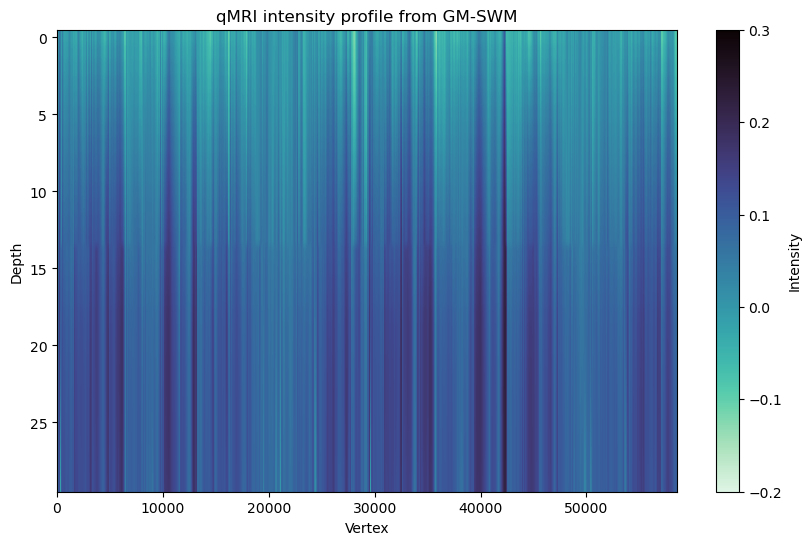

In [56]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.imshow(int_profile[:, mask_32k], aspect='auto', cmap='mako_r', vmin=-0.2, vmax=0.3)
plt.colorbar(label='Intensity')
plt.title('qMRI intensity profile from GM-SWM')
plt.xlabel('Vertex')
plt.ylabel('Depth')
plt.show()

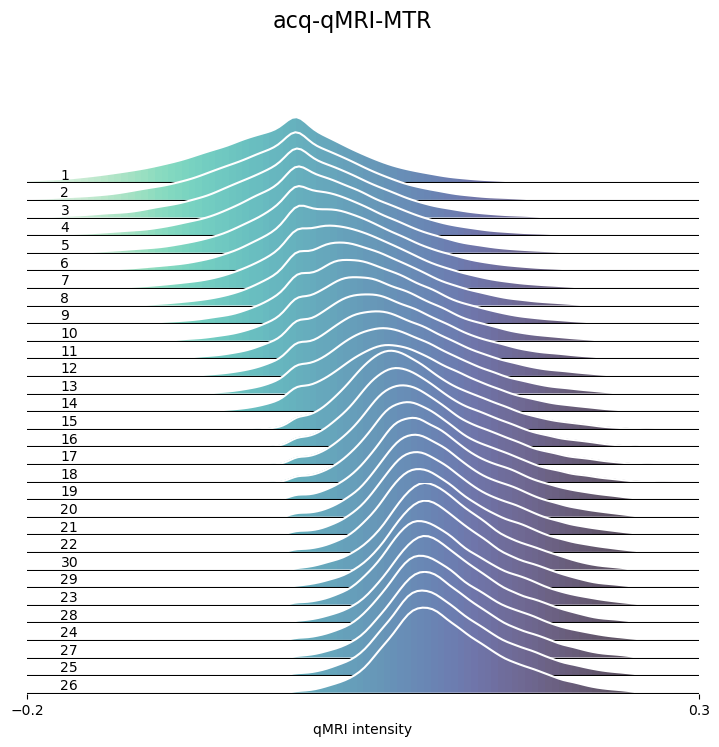

In [57]:
plot_ridgeplot(int_profile[:,mask_32k], matrix_df=None, Cmap='mako_r', 
               Range=(-0.2, 0.3), Xlab="qMRI intensity", save_path=None, title= qmri)


# Mean Intensity profile

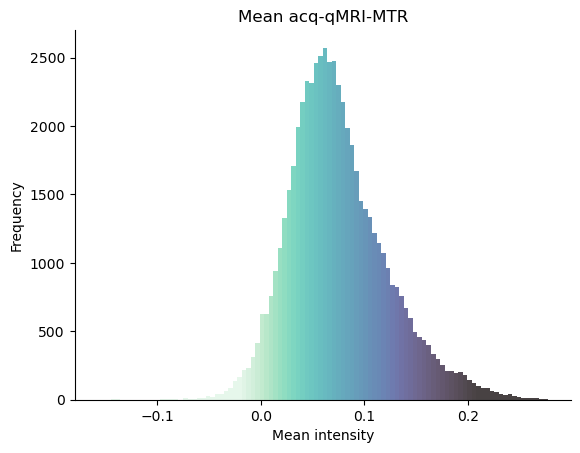

In [152]:
# Mean intensity profile
map_mean = np.mean(int_profile, axis=0)


def plot_colored_histogram(map_mean, nbins=100, cmap='mako_r', val_range=[0.01, 0.99], 
                           alpha=0.75, xlab='x-values', Title='', qt_col=True):
    
    # Remove NaN from the variance
    var_ft = map_mean[~np.isnan(map_mean)]
    n, bins = np.histogram(var_ft, bins=nbins)  # Compute the histogram data
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers
    
    if qt_col == True:
        val_range = [np.quantile(map_mean, val_range[0]), np.quantile(map_mean, val_range[1])]

    # Use colormap
    cmap = sns.color_palette(cmap, as_cmap=True)
    colored_bins = cmap(np.interp(bin_centers, val_range, [0, 1]))

    # Create a figure with a transparent background
    fig, ax = plt.subplots()
    fig.patch.set_alpha(0.0)  # Set the background of the figure to be transparent
    ax.patch.set_alpha(0.0)  # Set the background of the axes to be transparent

    # Plot the histogram with the desired colormap
    plt.bar(bin_centers, n, width=np.diff(bins), color=colored_bins, alpha=alpha)

    # Remove upper and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Customize ticks and labels
    plt.xlabel(xlab, fontsize=10)  # Increase font size for x-label
    plt.ylabel('Frequency', fontsize=10)  # Increase font size for y-label
    plt.title(Title, fontsize=12)  # Increase font size for title
    
    # Adjust x-axis values to match val_range if qt_col is False
    if not qt_col:
        ax.set_xlim(val_range)

    plt.show()

# Plot the histogram of the mean intensities exluding the midwall
plot_colored_histogram(map_mean[mask_32k], nbins=100, cmap='mako_r', qt_col=True,
                       val_range=[0.01, 0.99], alpha=0.75, xlab='Mean intensity', Title=f'Mean {qmri}')
    

# Statistical moments by deepth

In [110]:
# Calculate the mean on axis=1
mean_intensity = np.mean(int_profile, axis=1)
std_intensity = np.std(int_profile, axis=1)
skew_intensity = skew(int_profile, axis=1)
kurt_intensity = kurtosis(int_profile, axis=1)

def plot_deepth(ax, intensity_moment, title='', cbar=None, xlab='', cmap='mako_r'):
    # Create a scatter plot with lines
    ax.patch.set_alpha(0.0)  # Set the background of the axes to be transparent

    # Scatter plot with lines
    deepth = np.arange(2.8, -3.2, -0.2)
    ax.plot(intensity_moment, deepth, color='gray', alpha=0.5)
    scatter = ax.scatter(intensity_moment, deepth, c=intensity_moment, cmap=cmap, s=100, alpha=1)

    # Customize ticks and labels
    ax.set_xlabel(xlab, fontsize=14)  # Increase font size for x-label
    ax.set_ylabel('Deepth from WM', fontsize=14)  # Increase font size for y-label
    ax.set_title(title, fontsize=24)  # Increase font size for title

    # Remove upper and right lines of the boxplot
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Draw horizontal striped lines
    ax.axhline(y=0, color='lightgray', linestyle='--', linewidth=2)
    ax.axhline(y=-1.8, color='lightgray', linestyle='--', linewidth=2)
    
    if cbar:
        # Add color bar at the bottom
        cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.2)
        cbar.set_label(xlab)

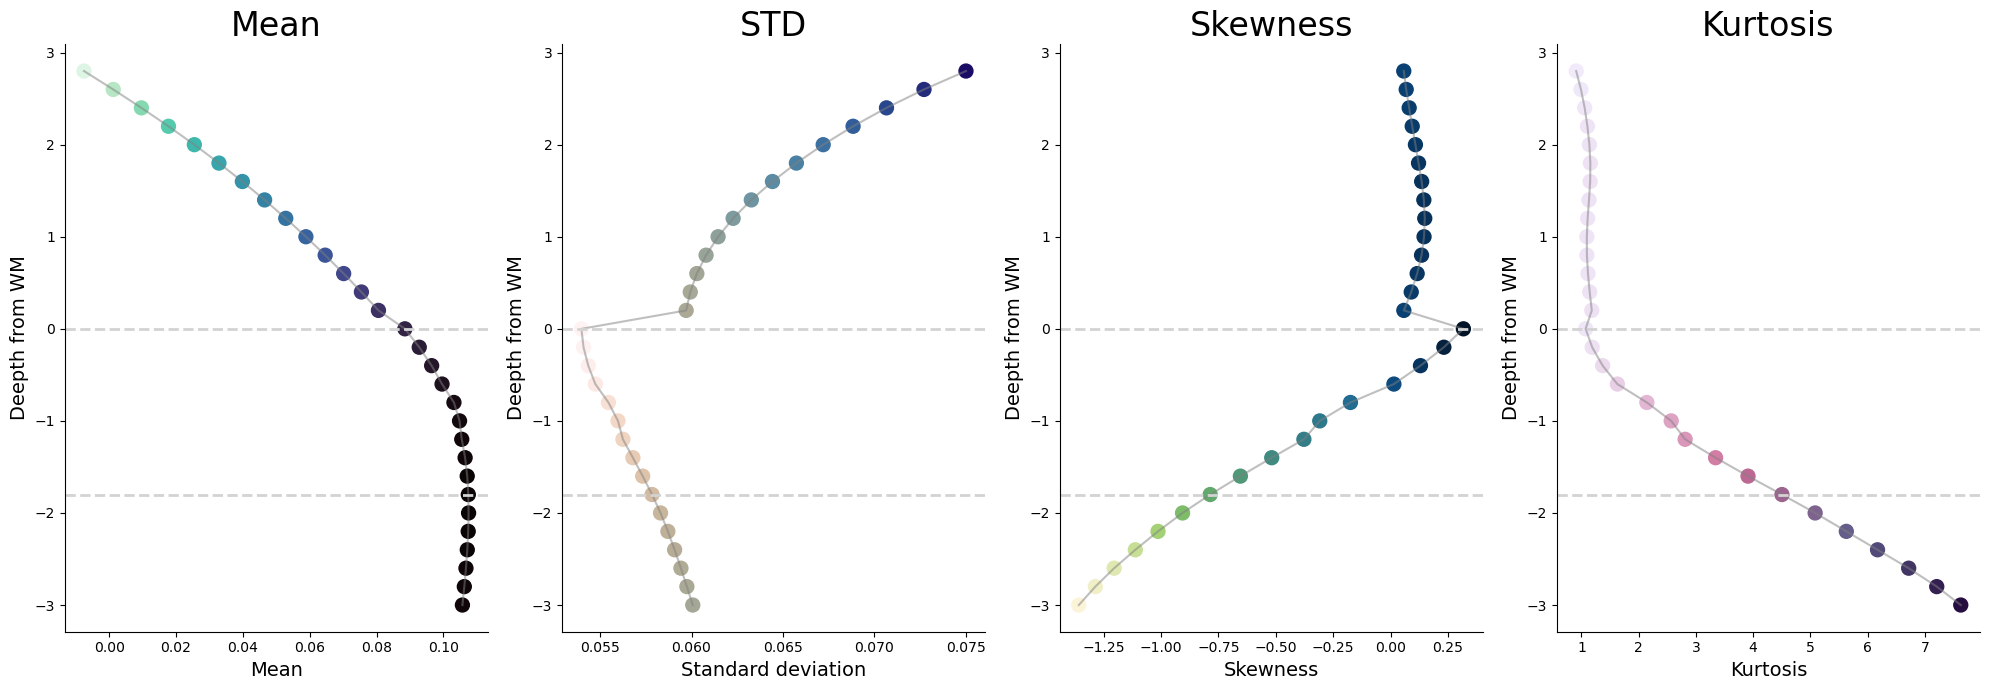

In [111]:
from cmcrameri import cm

# Create a 1x4 subplot layout
fig, axs = plt.subplots(1, 4, figsize=(20, 7))
fig.patch.set_alpha(0.0)  # Set the background of the figure to be transparent

# Plot each moment
plot_deepth(axs[0], mean_intensity, title='Mean', cbar=None, xlab='Mean', cmap='mako_r')
plot_deepth(axs[1], std_intensity, title="STD", cbar=None, xlab='Standard deviation', cmap='cmc.lapaz_r')
plot_deepth(axs[2], skew_intensity, title='Skewness', cbar=None, xlab='Skewness', cmap='cmc.navia_r')
plot_deepth(axs[3], kurt_intensity, title='Kurtosis', cbar=None, xlab='Kurtosis', cmap='cmc.acton_r')

plt.tight_layout()
plt.show()

## Partial volume effect (negatives values)

> **NOTE:** remove all the negatives values on the qMRI maps before running `MPC` and `MPC-SWM`. Ideally we should make transform all the values to **NaN**.

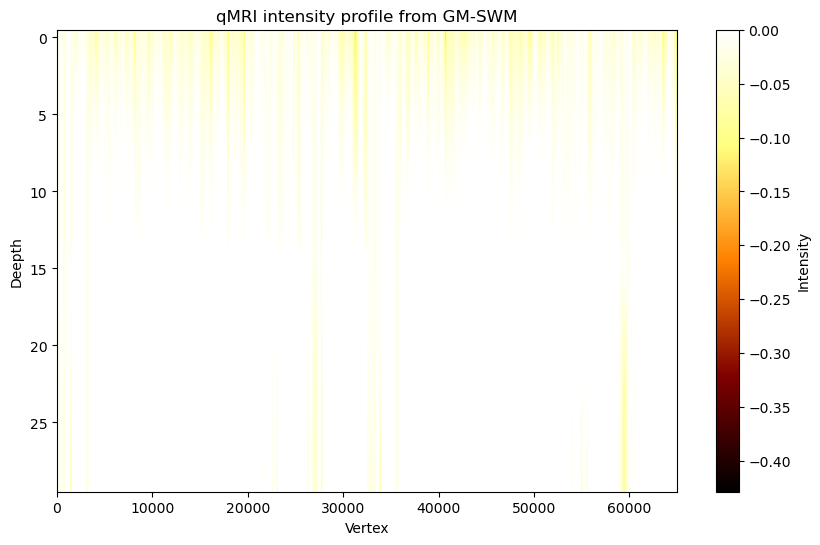

In [114]:
# Copy the intensity profile
int_thr = np.copy(int_profile)

# Threshol the values above 0
int_thr[int_thr > 0] = 0

# Create the plot
plt.figure(figsize=(10, 6))
plt.imshow(int_thr, aspect='auto', cmap='afmhot')
plt.colorbar(label='Intensity')
plt.title('qMRI intensity profile from GM-SWM')
plt.xlabel('Vertex')
plt.ylabel('Deepth')
plt.show()

## Sum of the Partial volume effect (negatives values)

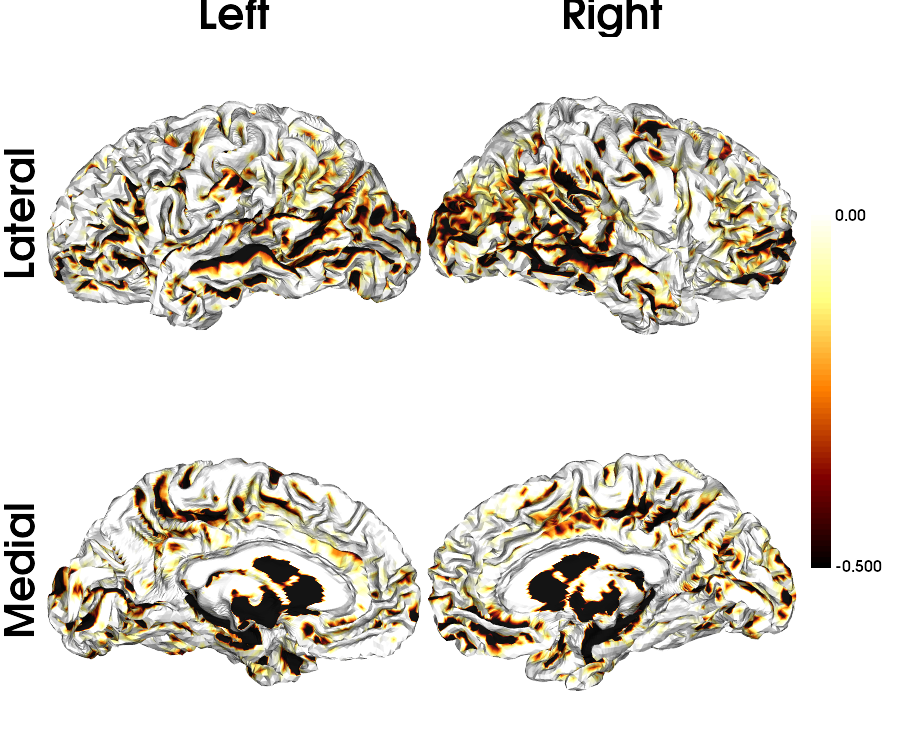

In [113]:
# Sum of the negative values to get a map of the areas with higher interpolation
neg_vals = np.sum(int_thr, axis=0)

# Plot the values on surface
plot_hemispheres(nat_32k_lh, nat_32k_rh, array_name=neg_vals, cmap='afmhot', nan_color=(0, 0, 0, 1), transparent_bg=True,
                  zoom=1.3, size=(900, 750), embed_nb=True, color_bar='right', layout_style='grid', color_range=(-0.5,0),
                  label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}, screenshot=False)



In [117]:
def plot_connectome(mtx, Title='matrix plot', xlab='X', ylab='Y', col='rocket', vmin=None, vmax=None,
                   xticklabels='auto', yticklabels='auto',xrot=90, yrot=0):
    
    '''
    This optional function, only plots a connectome as a heatmap
    Parameters
    ----------
    mtx : np.array
    Returns
    -------
    f : plot
    '''
    f, ax = plt.subplots(figsize=(15,10))
    g = sns.heatmap(mtx, ax=ax, cmap=col, vmin=vmin, vmax=vmax, xticklabels=xticklabels, yticklabels=yticklabels)
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)
    g.set_title(Title)
    # Rotate the x-axis labels
    # rotate tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=xrot, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=yrot, ha='right')

# MPC of SWM and GM

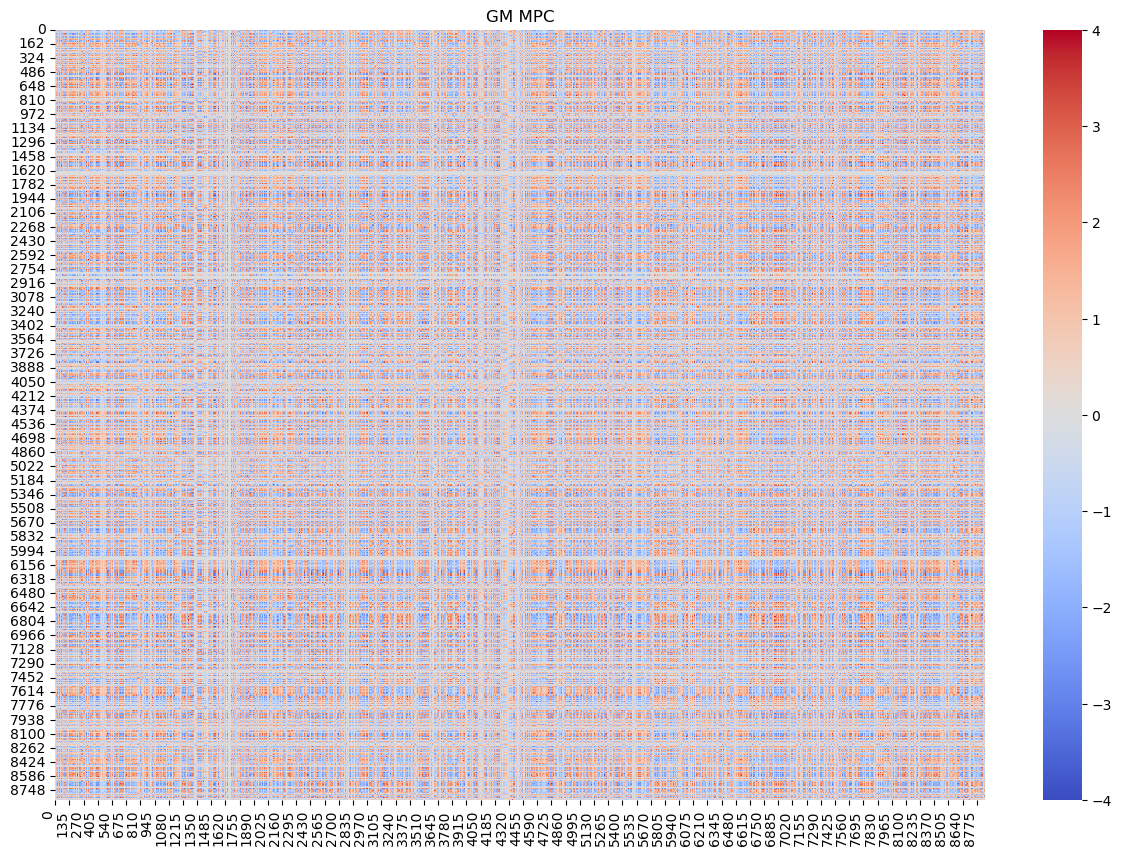

In [160]:
# remove the midwall vertices from the matrix
gm_mpc_masked = gm_mpc[mask_5k, :]
gm_mpc_masked = gm_mpc_masked[:, mask_5k]

# plot the matrix connectome
plot_connectome(gm_mpc_masked, Title='GM MPC', xlab='', ylab='', col='coolwarm', vmin=-4, vmax=4,
                   xticklabels='auto', yticklabels='auto',xrot=90, yrot=0)

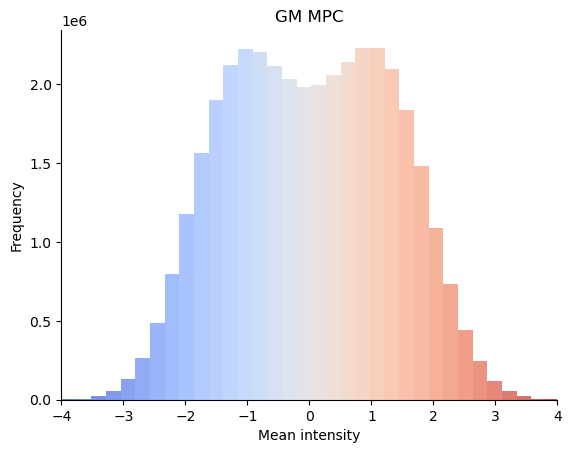

In [159]:
# Vectorize lower triangel and remove 0 values
# Extract the lower triangle of the matrix
gm_mpc_masked_vec = np.tril(gm_mpc_masked)

# Vectorize the lower triangle and remove zero values
gm_mpc_masked_vec = gm_mpc_masked_vec[gm_mpc_masked_vec != 0]

# Plot histogram of edges
plot_colored_histogram(gm_mpc_masked_vec, nbins=100, cmap='coolwarm', qt_col=False,
                       val_range=[-4, 4], alpha=0.75, xlab='Mean intensity', Title=f'GM MPC')


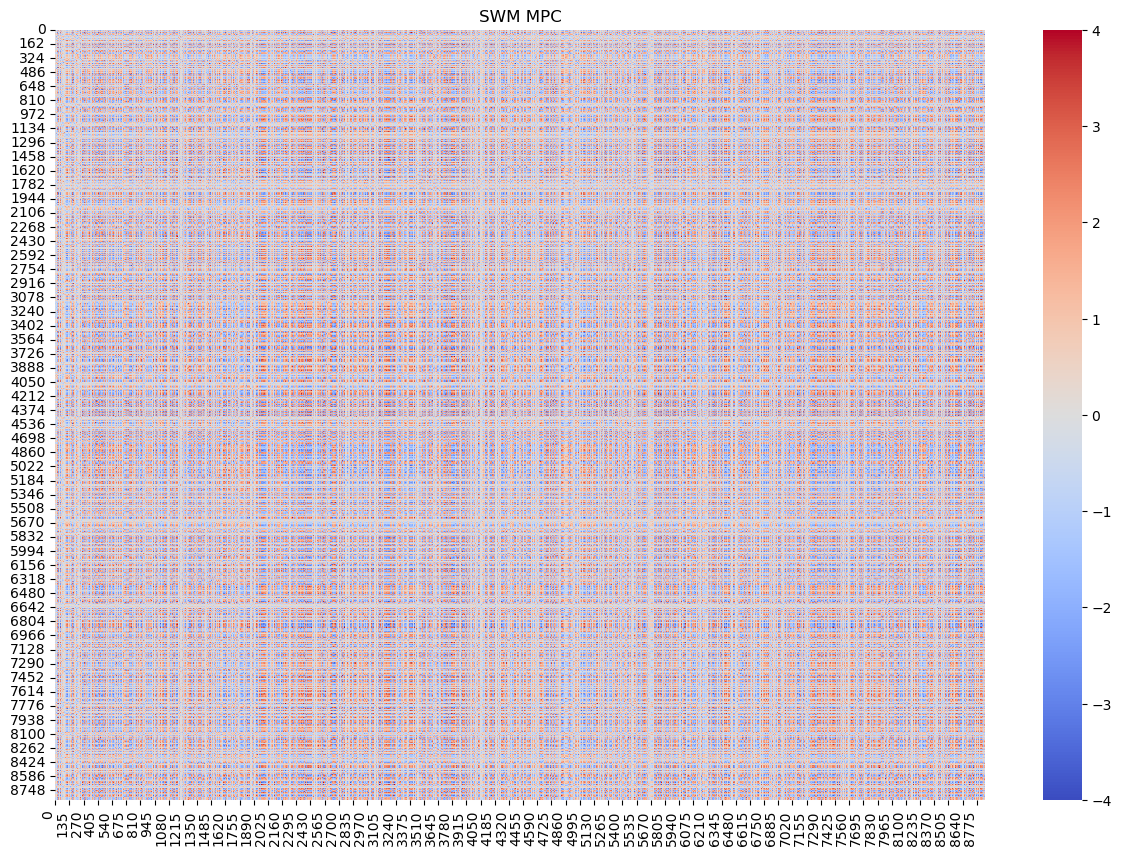

In [161]:
# remove the midwall vertices from the matrix
sw_mpc_masked = sw_mpc[mask_5k, :]
sw_mpc_masked = sw_mpc_masked[:, mask_5k]

# plot the matrix connectome
plot_connectome(sw_mpc_masked, Title='SWM MPC', xlab='', ylab='', col='coolwarm', vmin=-4, vmax=4,
                   xticklabels='auto', yticklabels='auto',xrot=90, yrot=0)

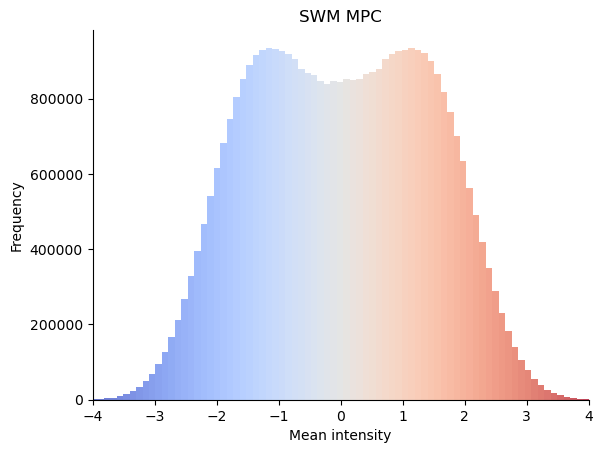

In [162]:
# Vectorize lower triangel and remove 0 values
sw_mpc_masked_vec = np.tril(sw_mpc_masked)

# Vectorize the lower triangle and remove zero values
sw_mpc_masked_vec = sw_mpc_masked_vec[sw_mpc_masked_vec != 0]

# Plot histogram of edges
plot_colored_histogram(sw_mpc_masked_vec, nbins=100, cmap='coolwarm', qt_col=False,
                       val_range=[-4, 4], alpha=0.75, xlab='Mean intensity', Title=f'SWM MPC')


# mean MPC of SWM and GM on surface

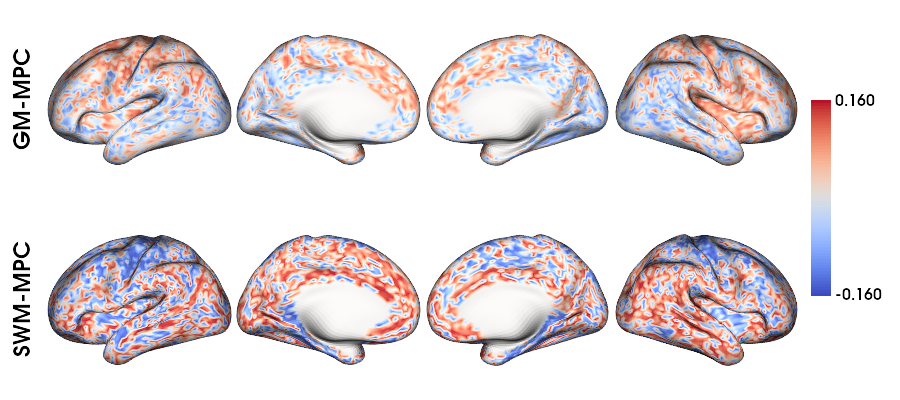

In [231]:
# Inflate the INFLATED surface 10% reference to the sphere
mpcs = [np.mean(gm_mpc,axis=0)*mask_5k, np.mean(sw_mpc,axis=0)*mask_5k]
mpcs_labels = ['GM-MPC', 'SWM-MPC']

plot_hemispheres(inf_lh, inf_rh,  mpcs,size=(900, 400), zoom=1.25, embed_nb=True, 
                 interactive=False, share='both', cmap='coolwarm', color_range='sym', color_bar='right',
                 nan_color=(0, 0, 0, 1),  transparent_bg=True, label_text={'left': mpcs_labels},
                 screenshot=False, scale=1)

    

# mean MPC similarity between GM and SWM

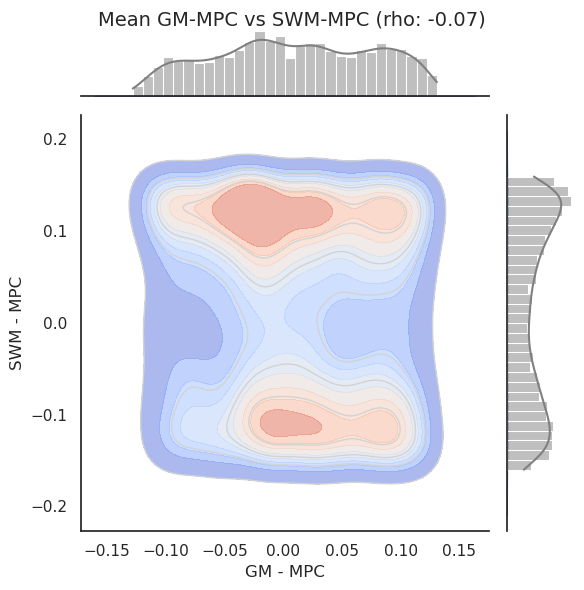

In [228]:
# Flatten the arrays to 1D and apply the mask
mpc_gm = mpcs[0][mask_5k]
mpc_sw = mpcs[1][mask_5k]

# Filter out zero values
mpc_gm = mpc_gm[mpc_sw != 0]
mpc_sw = mpc_sw[mpc_sw != 0]

# Calculate the correlation coefficient
correlation = np.corrcoef(mpc_gm, mpc_sw)[0, 1]

# Create a scatter plot with marginal histograms
sns.set(style="white")
g = sns.jointplot(x=mpc_gm, y=mpc_sw, kind="kde", cmap="coolwarm", alpha=0.5, fill=True)

# Add a contour plot
sns.kdeplot(x=mpc_gm, y=mpc_sw, ax=g.ax_joint, levels=5, color="lightgray", linewidths=1)

# Add marginal histograms as bar plots
g.plot_marginals(sns.histplot, kde=True, color="gray", bins=30)

# Set labels and title
g.set_axis_labels('GM - MPC', 'SWM - MPC', fontsize=12)
g.fig.suptitle(f'Mean GM-MPC vs SWM-MPC (rho: {correlation:.2f})', fontsize=14)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)  # Adjust title position

plt.show()

In [236]:
# Smooth intencities
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional Number of smooth iterations
    Relax  : relax : float, optional relaxation factor
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l=Mask[0:n2dim]
    Mask_r=Mask[n2dim:Ndim]
    sdata = np.concatenate((smooth_array(surf_l, points[0:n2dim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[n2dim:Ndim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)

# Create the gradients from the MPC matrix
def mpc_dm(MPC, mpc_mask, Ngrad=5, kernel='normalized_angle', sparcity=0.9):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel=kernel)
    MPCgm.fit(MPC_masked, sparsity=sparcity)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mpc_mask.shape, np.nan)
        g_nan[indx] = g

        # fill in the calculated values into the corresponding indices of the new array
        grad[i] = g_nan
    
    return(MPCgm, grad)

def map_to_labels5k(mpc_sliced, mask):
    # Get the index of the non medial wall regions
    mask_indx = np.where(mask==1)[0]
    # map to the labels
    labels_5k = np.full(mask.shape, np.nan)
    labels_5k[mask_indx] = mpc_sliced
    return(labels_5k)

# Dimensionality reduction of MPC

In [237]:
# DM-GM Surface
gm_dm, gm_eigen = mpc_dm(gm_mpc, mask_5k, sparcity=0)

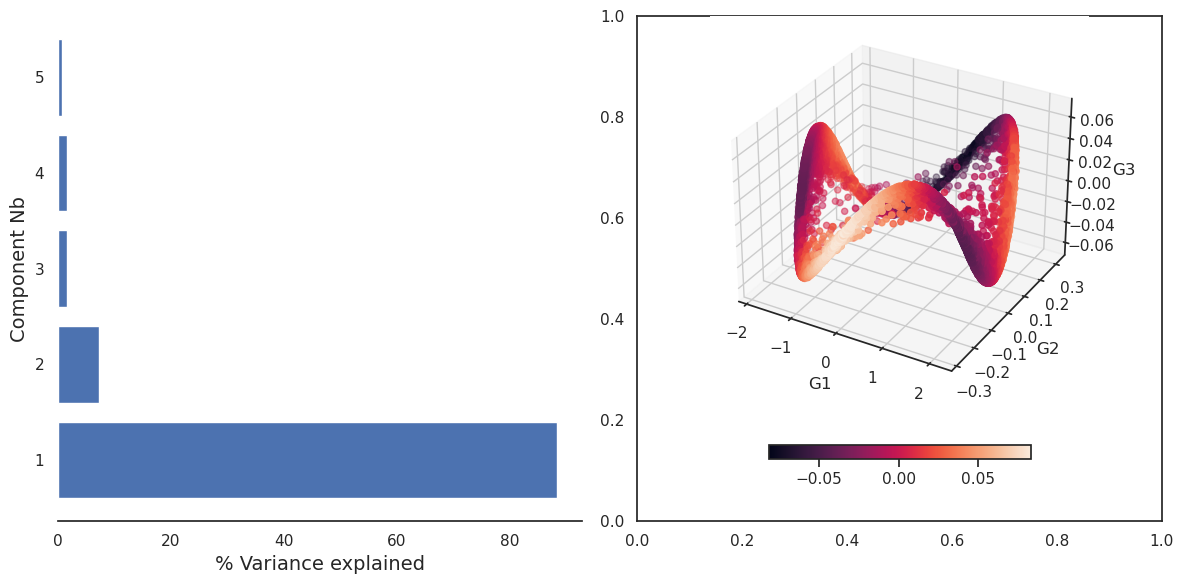

In [309]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming gm_dm.lambdas_ and gm_dm.gradients_ are already defined
gm_dm_var = gm_dm.lambdas_ / np.sum(gm_dm.lambdas_) * 100
gradients = gm_dm.gradients_

# Create a 1x2 plotting layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Horizontal bar chart
y = range(1, gm_dm.lambdas_.size + 1)
ax1.barh(y, gm_dm_var, align='center')

# Set labels for Plot 1 with increased font size
ax1.set_ylabel('Component Nb', fontsize=14)
ax1.set_xlabel('% Variance explained', fontsize=14)

# Remove upper and right box lines for Plot 1
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Plot 2: 3D scatter plot
ax2 = fig.add_subplot(122, projection='3d')
sc = ax2.scatter(gradients[:, 0], gradients[:, 1], gradients[:, 2], c=gradients[:, 3], cmap='rocket')

# Add color bar to Plot 2
cbar = plt.colorbar(sc, ax=ax2, orientation='horizontal', pad=0.1, shrink=0.5)

# Set labels for Plot 2
ax2.set_xlabel('G1')
ax2.set_ylabel('G2')
ax2.set_zlabel('G3')

# Show plot
plt.tight_layout()
plt.show()

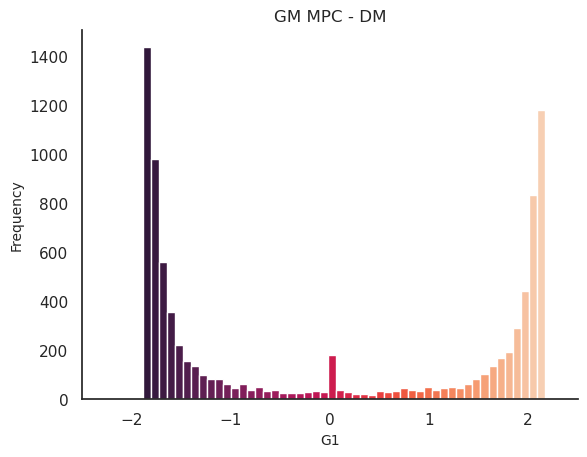

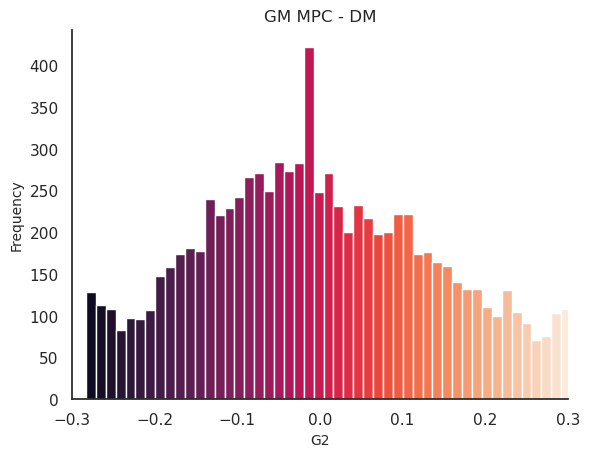

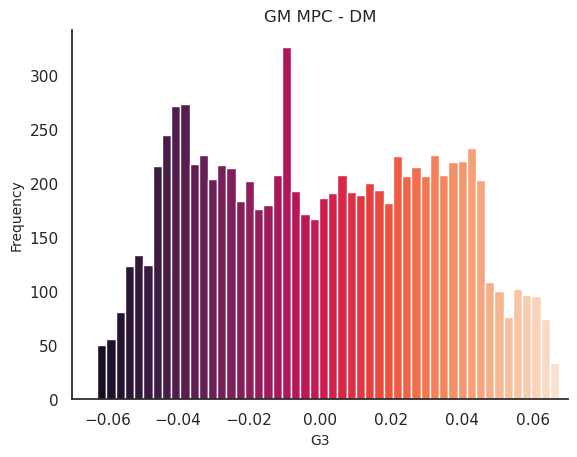

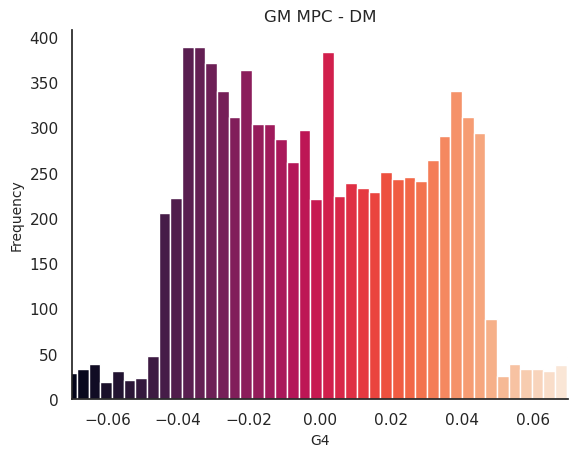

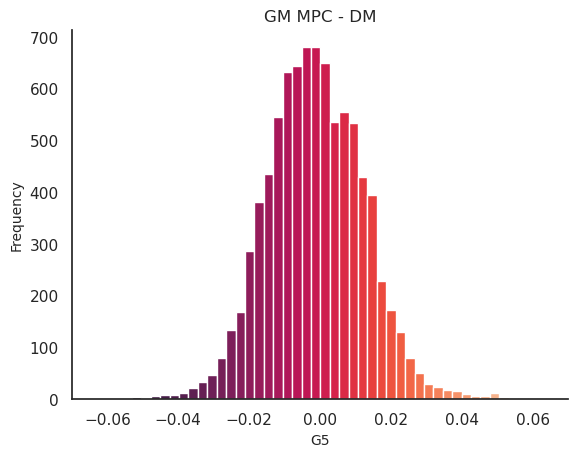

In [310]:
# Plot histogram of edges
plot_colored_histogram(gm_dm.gradients_.T[0,:], nbins=50, cmap='rocket', qt_col=False,
                       val_range=[-2.5, 2.5], alpha=1, xlab='G1', Title=f'GM MPC - DM')
plot_colored_histogram(gm_dm.gradients_.T[1,:], nbins=50, cmap='rocket', qt_col=False,
                       val_range=[-0.3, 0.3], alpha=1, xlab='G2', Title=f'GM MPC - DM')
plot_colored_histogram(gm_dm.gradients_.T[2,:], nbins=50, cmap='rocket', qt_col=False,
                       val_range=[-0.07, 0.07], alpha=1, xlab='G3', Title=f'GM MPC - DM')
plot_colored_histogram(gm_dm.gradients_.T[3,:], nbins=50, cmap='rocket', qt_col=False,
                       val_range=[-0.07, 0.07], alpha=1, xlab='G4', Title=f'GM MPC - DM')
plot_colored_histogram(gm_dm.gradients_.T[4,:], nbins=50, cmap='rocket', qt_col=False,
                       val_range=[-0.07, 0.07], alpha=1, xlab='G5', Title=f'GM MPC - DM')

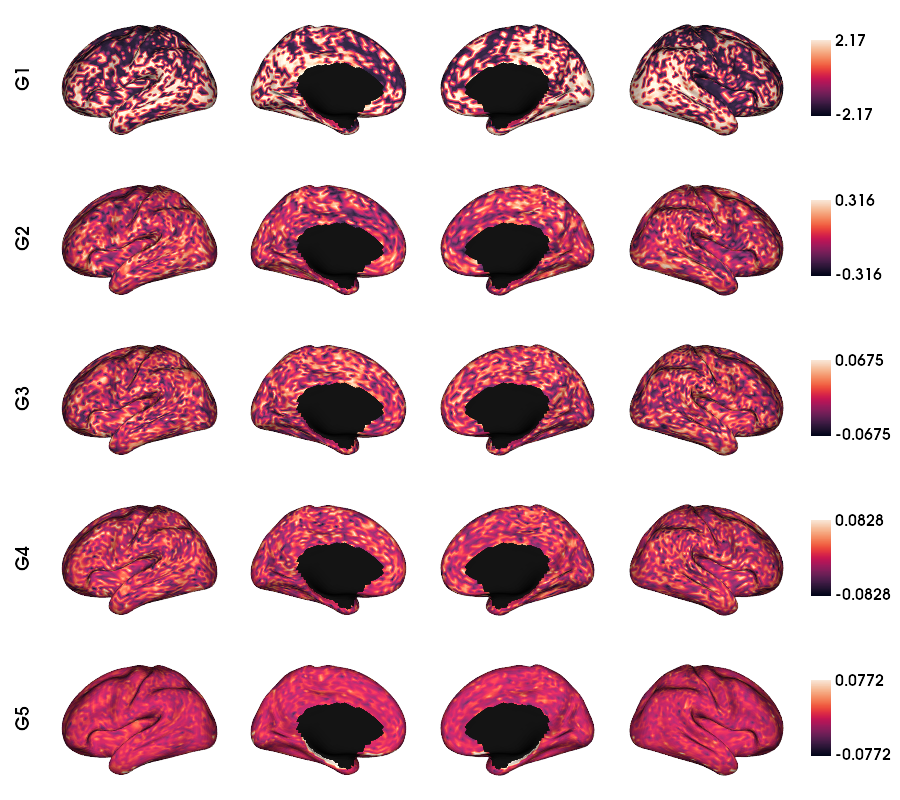

In [311]:
# Number of gradients
Ngrad=5

# Create the labels
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]

# DM-GM Surface
plot_hemispheres(inf_lh, inf_rh,  gm_eigen, size=(900, 800), zoom=1.25, embed_nb=True, 
                 interactive=False, cmap='rocket', color_range='sym', color_bar='right',
                 nan_color=(0, 0, 0, 1),  transparent_bg=True, label_text={'left': labels},
                 screenshot=False, scale=1)


In [ ]:
# DM-SWM surface

In [ ]:
# DM-SWM Scatterplot